In [5]:
from datetime import datetime as dt
dt.now().date

In [11]:
dt.now().date().strftime('%D')

'06/14/22'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import (StandardScaler, 
                                   PowerTransformer, 
                                   MinMaxScaler, 
                                   RobustScaler,
                                   MaxAbsScaler,
                                   QuantileTransformer)
import seaborn as sns
import utils
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
pd.set_option('display.precision',2)
pd.set_option('display.max_rows', 100)
pd.set_option("display.max.columns", None)
plt.style.use('bmh')
%load_ext autoreload
%autoreload 2

## We start by creating several subset datasets


In [3]:
ix = [(df.columns.get_level_values(1).str.endswith('score')) &
      (df.columns.get_level_values(1).str.contains('avg|final'))]
scores = df[df.columns[ix]].astype(float)

ix = [(df.columns.get_level_values(1).str.contains('ms'))]
response_time = df[df.columns[ix]].astype(float)

info = df.xs('info',1)

In [4]:
response_time

task,spatial_span,grammatical_reasoning,double_trouble,odd_one_out,monkey_ladder,rotations,feature_match,digit_span,paired_associates,polygons,token_search
measure,avg_ms_per_item,avg_ms_correct,avg_ms_correct,avg_ms_correct,avg_ms_per_item,avg_ms_correct,avg_ms_correct,avg_ms_per_item,avg_ms_per_item,avg_ms_correct,avg_ms_per_item
"(info, user)",,,,,,,,,,,
45312,2052.07,4078.84,1898.16,9761.88,1604.18,5096.40,3790.74,1111.91,3857.64,3435.27,2137.65
45315,1842.61,3081.29,2303.32,8570.00,1447.96,5196.09,2640.16,2465.78,3762.21,2854.10,1714.03
45318,1943.73,4056.44,2043.00,8991.59,1495.89,3787.11,2708.46,1127.11,3485.29,3072.78,1488.66
45319,1900.49,3313.86,1713.92,7359.31,NaN,4153.44,2560.20,1136.29,3551.64,3041.45,NaN
45320,NaN,4515.54,2617.04,NaN,1612.51,NaN,2885.67,1401.08,3604.55,3191.65,NaN
...,...,...,...,...,...,...,...,...,...,...,...
102962,2032.44,3129.38,3163.50,5676.60,1797.69,NaN,2988.54,1413.74,4016.29,3291.82,2355.80
103072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


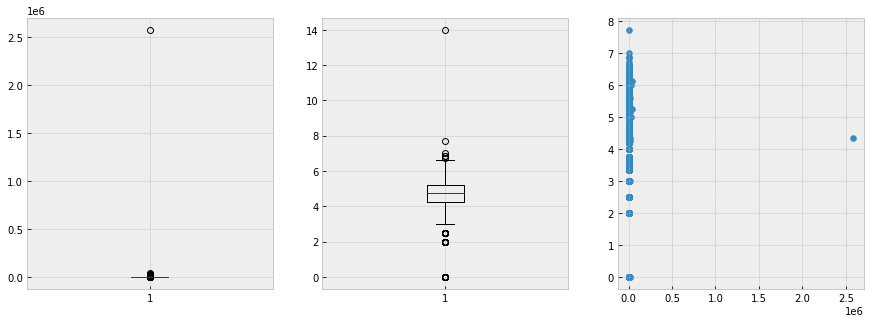

In [156]:
fig,ax = plt.subplots(1,3,figsize=(15,5))

rt = response_time.iloc[:,0]
score = scores.iloc[:,0]
ax[0].boxplot(rt.dropna().to_numpy())
ax[1].boxplot(score.dropna().to_numpy())
ax[2].scatter(rt,score)

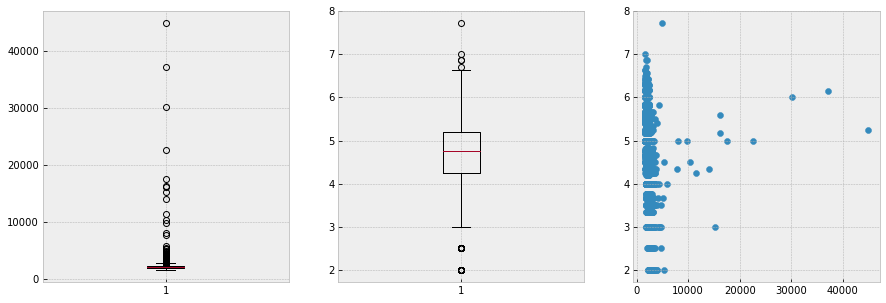

In [161]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
task = rt.name[0]
rt = response_time.iloc[:,0]
score = scores.iloc[:,0]
data = pd.concat([rt.rename('rt'),score.rename('score')],axis=1)
data = data.query('rt < 1e6 & (0 < score < 10)').dropna()
ax[0].boxplot(data.rt)
ax[1].boxplot(data.score)
ax[2].scatter(data.rt,data.score)

[Text(0.5, 0, 'avg_ms_per_item'), Text(0, 0.5, 'avg_score')]

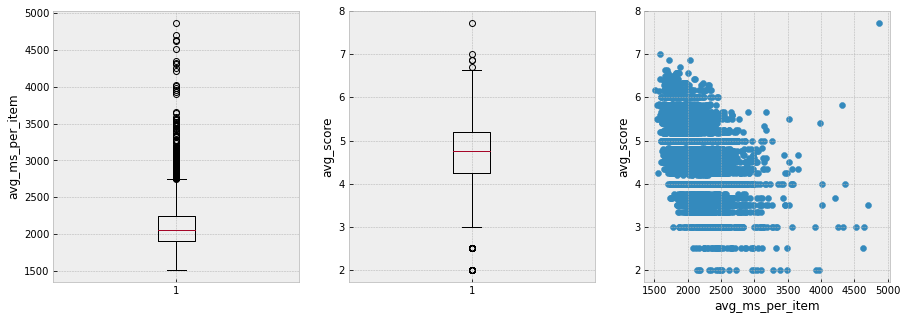

In [165]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
rt = response_time.iloc[:,0]
score = scores.iloc[:,0]

task = rt.name[0]
rt_metric = rt.name[1]
score_metric = score.name[1]

data = pd.concat([rt.rename('rt'),score.rename('score')],axis=1)
data = data.query('rt < 5e3 & (0 < score < 10)').dropna()
ax[0].boxplot(data.rt)
ax[0].set_ylabel(rt_metric)
ax[1].boxplot(data.score)
ax[1].set_ylabel(score_metric)
ax[2].scatter(data.rt,data.score)
ax[2].update(dict(xlabel = rt_metric, ylabel = score_metric))

In [172]:
data = pd.concat([rt.rename('rt'),score.rename('score')],axis=1).dropna()
dpgmm = BayesianGaussianMixture(n_components=2, covariance_type="full").fit(data)
data = data.assign(outlier = dpgmm.predict(data))

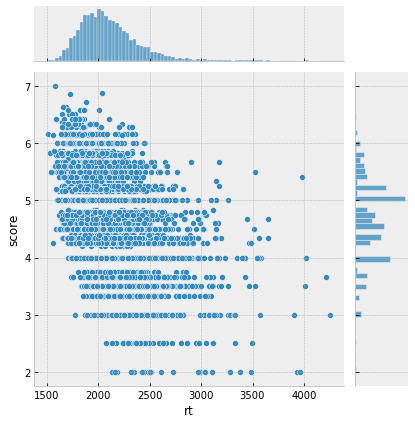

In [178]:
sns.jointplot(data = data[data.outlier==0], x= 'rt',y='score')

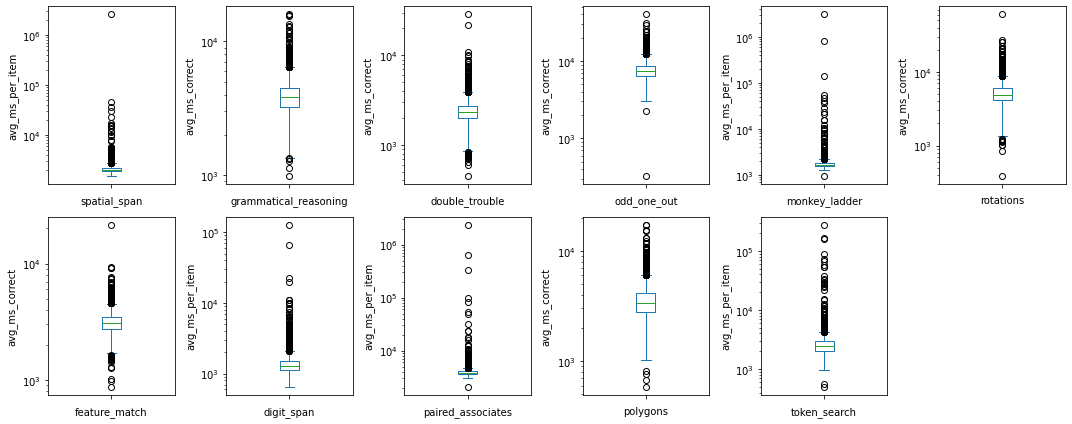

In [106]:
fig,ax = plt.subplots(2,6,figsize=(15,6))
ax = ax.flat
for i,col in enumerate(response_time):
     response_time[col].dropna().rename('').plot.box(ax=ax[i])
     ax[i].set_ylabel(col[1])
     ax[i].set_xlabel(col[0])
     ax[i].set_yscale('log')
fig.delaxes(ax[i+1])    
plt.tight_layout()     


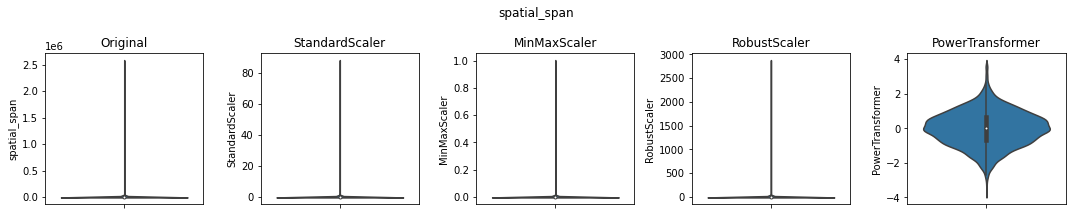

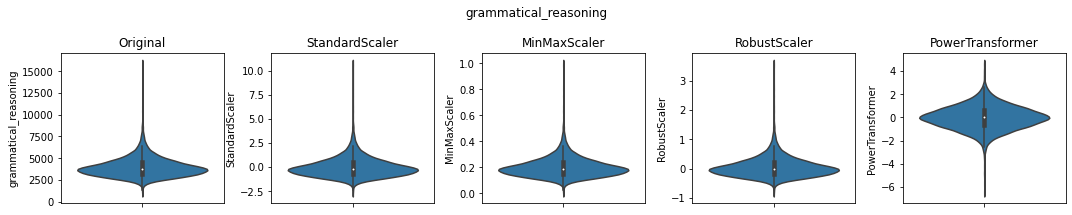

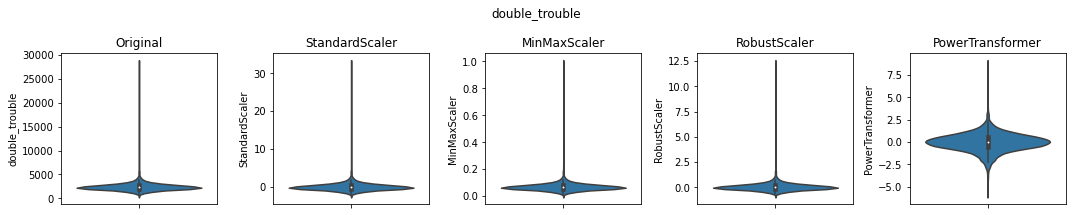

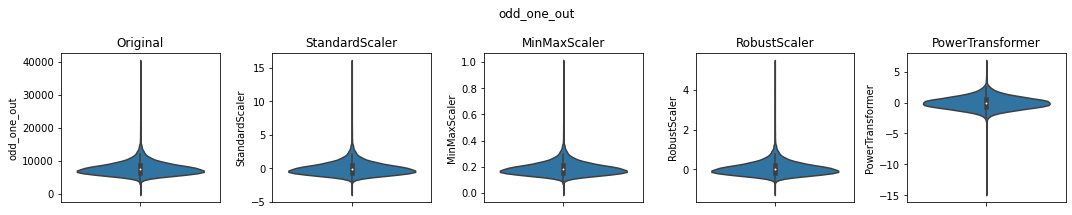

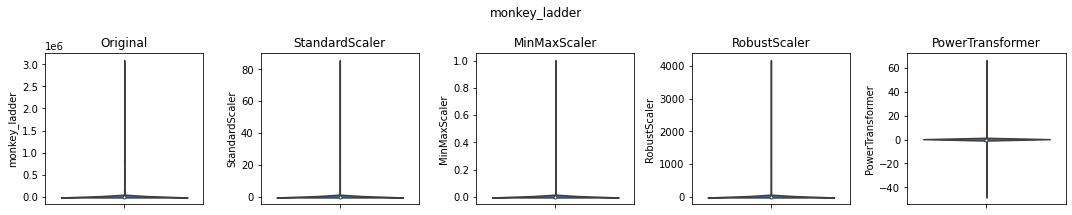

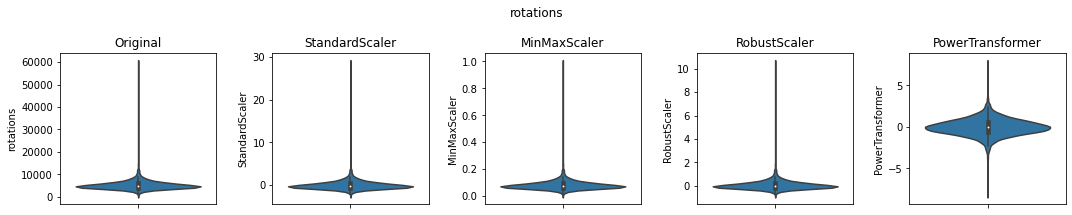

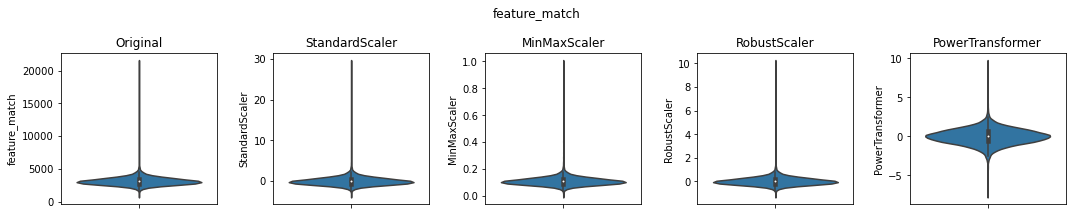

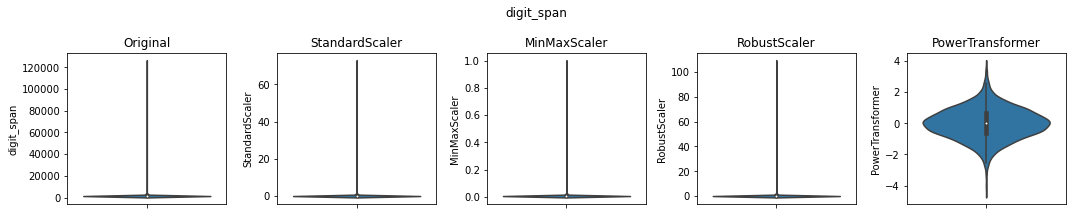

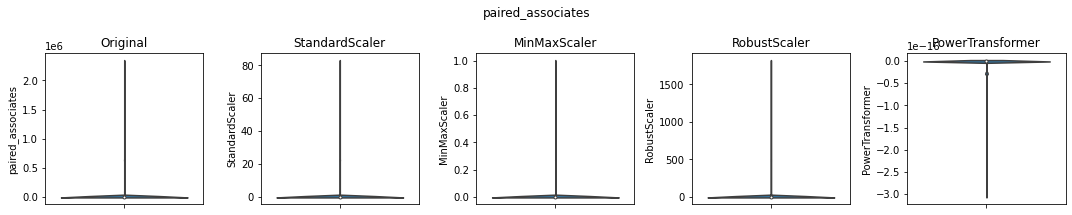

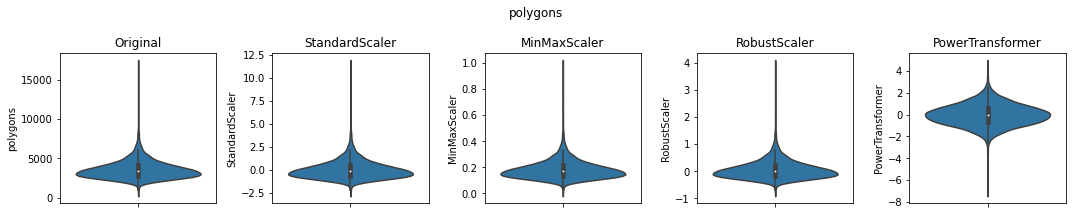

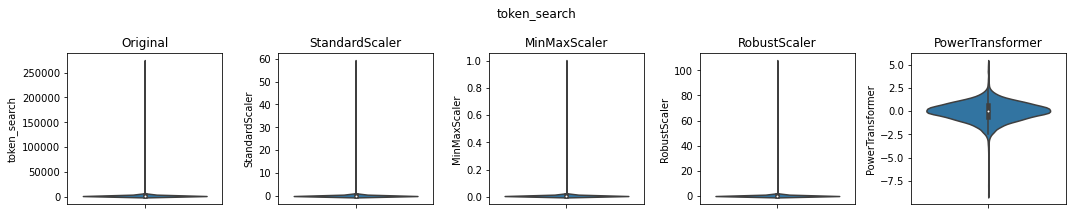

In [109]:
for col in response_time:
    fig,ax = plt.subplots(1,5,figsize=(15,3))
    rt = response_time[col].to_frame().droplevel(1,1)
    sns.violinplot(y = rt[col[0]],ax=ax[0])
    ax[0].set_title('Original')
    for i,scaler in enumerate([StandardScaler(), 
                               MinMaxScaler(), 
                               RobustScaler(quantile_range=(5, 95)),
                               PowerTransformer(method="yeo-johnson")]):
        name = scaler.__class__.__name__
        tmp = pd.DataFrame(scaler.fit_transform(rt),columns=[name])
        sns.violinplot(y = tmp[name],ax=ax[i+1])
        ax[i+1].set_title(name)
    fig.suptitle(col[0])
    plt.tight_layout()  

In [86]:
from sklearn.mixture import BayesianGaussianMixture

def identify_extremes(feature,n_comp=2):
    index,x0 = feature.dropna().index,feature.dropna().to_numpy().reshape(-1,1)
    dpgmm = BayesianGaussianMixture(n_components=n_comp, covariance_type="full").fit(x0)
    y0 = dpgmm.predict(x0)
    output = pd.concat([feature,pd.Series(y0,index=index)],axis=1)
    output.columns = ['value','outlier']
    return output

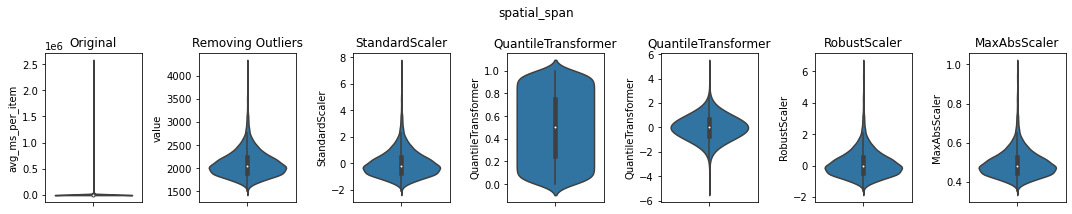

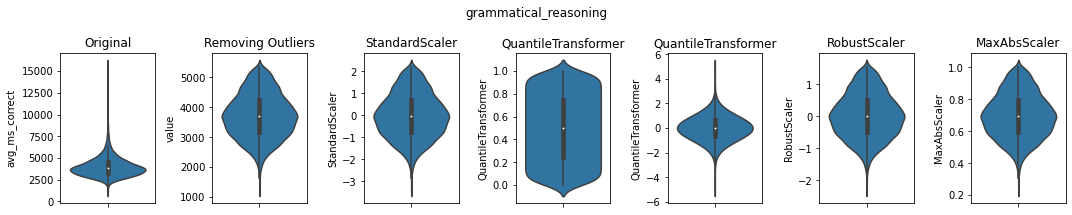

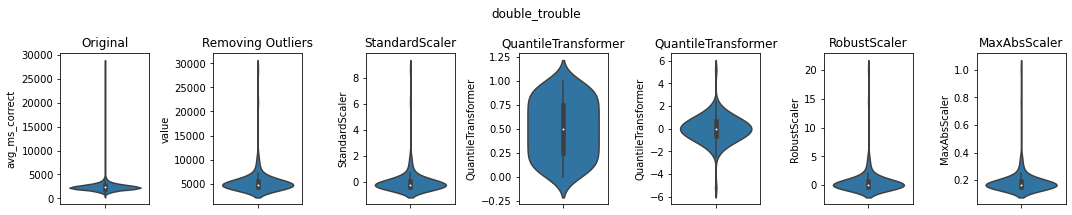

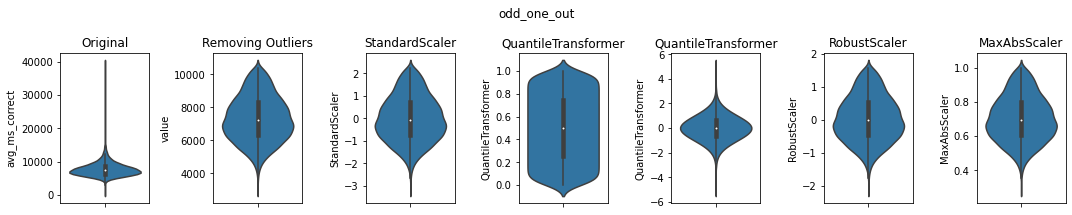

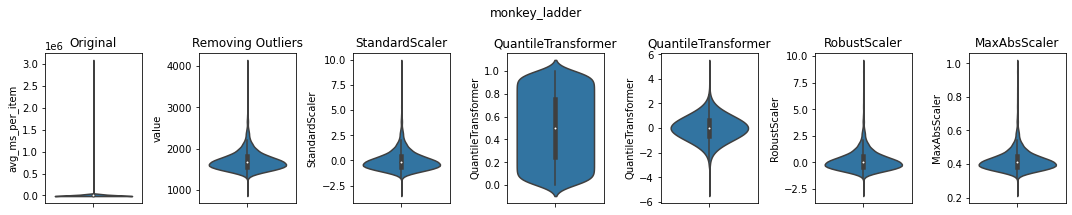

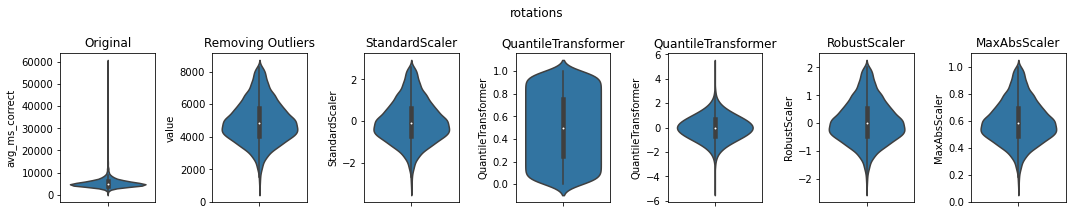

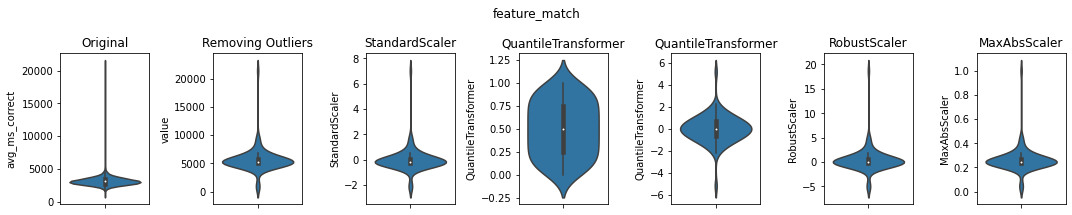

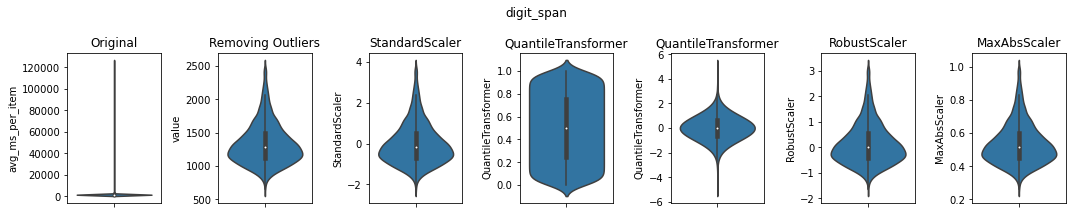

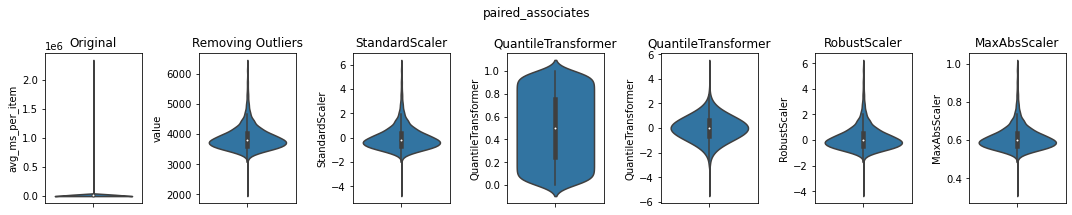

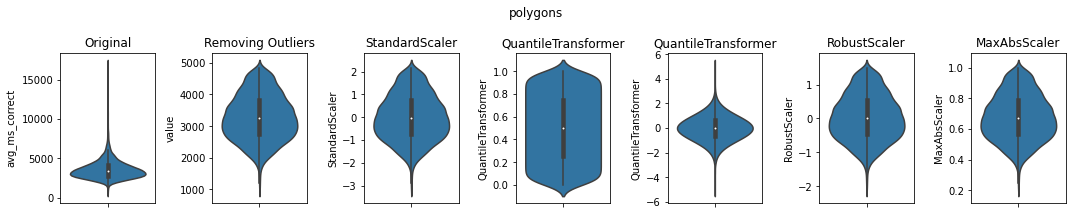

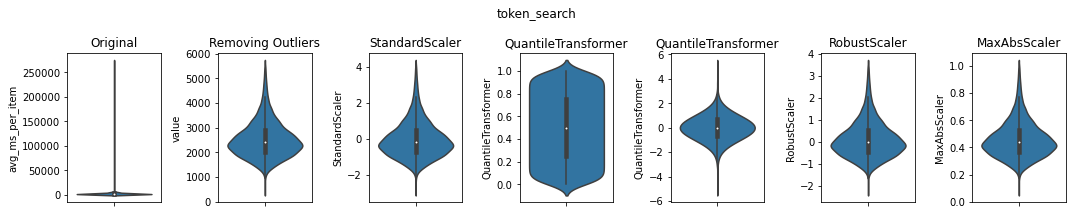

In [117]:
for col in response_time:
    fig,ax = plt.subplots(1,7,figsize=(15,3))
    rt = response_time[col].to_frame().droplevel(1,1)
    rt = identify_extremes(rt)
    sns.violinplot(y = 'value',data=rt,hue='outlier',ax=ax[0])
    ax[0].set_ylabel(col[1])
    sns.violinplot(y = rt[rt.outlier==0].value,ax=ax[1])
    ax[0].set_title('Original')
    ax[1].set_title('Removing Outliers')
    x0 = rt[rt.outlier==0].value.to_numpy().reshape(-1,1)
    for i,scaler in enumerate([StandardScaler(), 
                               QuantileTransformer(output_distribution="uniform"), 
                               QuantileTransformer(output_distribution="normal"),
                               RobustScaler(quantile_range=(25, 75)),
                               MaxAbsScaler()]):
        name = scaler.__class__.__name__
        tmp = pd.DataFrame(scaler.fit_transform(x0),columns=[name])
        sns.violinplot(y = tmp[name],ax=ax[i+2])
        ax[i+2].set_title(name)
    fig.suptitle(col[0])
    plt.tight_layout() 

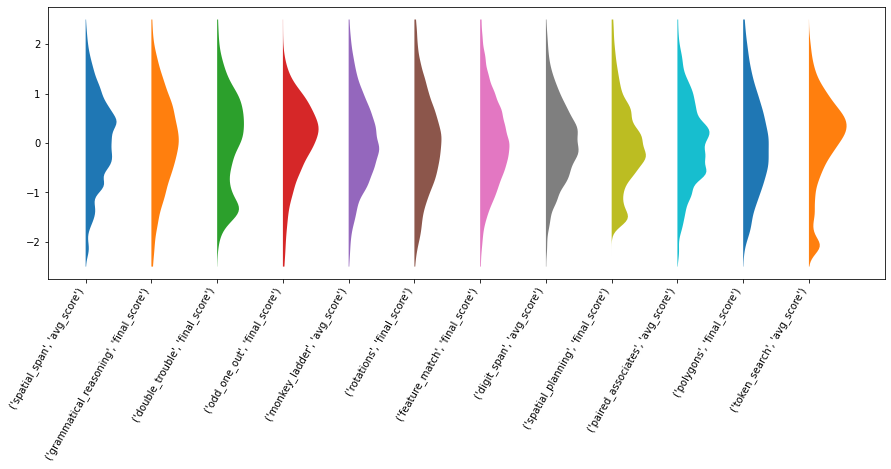

In [9]:
from scipy.stats import gaussian_kde
fig,ax = plt.subplots(figsize=(15,5))
x = np.linspace(-2.5,2.5,100)
scaler = StandardScaler()
scores_scaled = pd.DataFrame(scaler.fit_transform(scores),
                             columns = scores.columns)

for i,col in enumerate(scores_scaled):
    density = gaussian_kde(scores_scaled[col].dropna())
    y = density(x)
    ax.fill_betweenx(x,y+i,i)
ax.set_xticks(np.arange(scores_scaled.shape[1]))    
ax.set_xticklabels(scores_scaled.columns,rotation=60,ha='right');